# Determining Popular Topics for Data Science Content

## Introduction

As an employee of a data science content creator, we are tasked with determining the best subject matter(s) about which to write, which we interpret as the most popular data science topic(s) people want to learn. To inform us of the most in demand data science content, we investigate the [Data Science Stack Exchance](https://datascience.stackexchange.com) (DSSE) site, a popular question and answer site dedicated to the field.

The site welcomes practical, detailed questions about specific field-related issues encountered by users. These questions should be  focused, objective, and pertaining directly to data science; they should also generate succint answers, rather than discussions.

The site's homepage subdivides into five sections:
- Questions;
- Tags;
- Users;
- Unanswered;
- Jobs.

The Questions page contains all questions posted to the site; the Tags page contains a list of related tags, or keywords or labels, that categorize the questions based on the topic(s) to which they pertain; the Users page lists each user of the site; the Unanswered page contains all of the questions with no upvoted or accepted answers; and the Jobs page opens a link to the [Stack Overflow Jobs](https://stackoverflow.com/jobs) site.

Since we are interested in identifying the most popular data science topics, the Tags page, which lists the number of posts related to each topic, will be of particular use to us in our analysis, as it will allow us to categorize the posts automatically.

Each post contains a question, with title and body, a number of answers, scores for both the question and answers, with the score calculated as the number of upvotes minus the number of downvotes, and basic user information for the poster and respondent(s). Each post also shows the time since the question and answer(s) were first created and last edited, when the post was last active, the number of views, and a list of tags associated with the topic(s) of the post.


## Exploring Data Science Posts with Stack Exchange Data Explorer (SEDE)

We can access the post data stored on the DSSE site by querying its public database with [Stack Exchance Data Explorer](https://data.stackexchange.com) (SEDE), an open source tool for running queries over the Stack Exchange site's data, which is stored in relational databases. We use this tool to first investigate the tables available for the DSSE database and determine which tables may be of use to us in finding the most popular content on the site.  We will then query the SEDE DSSE database to extract the data we need to perform our analysis.

Based on our initial examination of the database and our interest in post popularity by category (to identify popular topics), we will want to focus our queries on the `Posts` table, which contains information about questions and answers, and the `Tags` table, which lists information about each topic tag. We may also need to include information from related tables, such as `PostTags`, `PostTypes`, and `TagSynonyms`.

Let's focus on the `Posts` table for now. Since we want to know which data science topics people are most interested in learning about, we are only concerned with **questions** asked on the site. We also only care about **recent** posts, as we are focused on topics that are currently popular. Therefore, we will only extract questions asked after 2018 from the post data. Additionally, not all of the information in each row is relevant to our inquiry, so we will select only the following columns:
- `Id` -- post identification number;
- `PostTypeId` -- post type identification number: `1 = Question`;
- `CreationType` -- date and time of creation of post;
- `Score` -- post's overall score (upvotes minus downvotes);
- `ViewCount` -- number of times post has been viewed;
- `Tags` -- associated topic tags;
- `AnswerCount` -- number of answers question received;
- `FavoriteCount` -- number of times question was favorited.

To extract the necessary data, we run the following query over the SEDE DSSE database:
```
SELECT Id, PostTypeId, CreationDate, Score, 
       ViewCount, Tags, AnswerCount, FavoriteCount
  FROM Posts
 WHERE (PostTypeId = 1) AND (CreationDate >= '2019-01-01')
ORDER BY Id;
```
The first several rows of the results of our query are shown below:

Id|PostTypeId|CreationDate|Score|ViewCount|Tags|AnswerCount|FavoriteCount
--|----------|------------|-----|---------|----|-----------|-------------
43363|1|2019-01-01 03:53:02|0|36|machine-learning nlp|1|
43366|1|2019-01-01 06:02:07|3|58|deep-learning convnet|image-classification|1|1
43367|1|2019-01-01 06:16:26|0|27|scikit-learn tensorflow|scipy|1|
43370|1|2019-01-01 10:06:03|2|37|classification|0|
43374|1|2019-01-01 13:18:02|3|38|deep-learning time-series cnn convolution|1|

## Exploring the Data for Analysis

The results of our query are stored in a file, `2019_questions.csv`, which we can read into a dataframe so we may further explore the data and perform our analysis.

In [1]:
# import the necessary libraries for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# read in the query results + parse creation dates
questions = pd.read_csv('2019_questions.csv', parse_dates=['CreationDate'])

In [2]:
# get summary for dataset
print(questions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB
None


In [3]:
# look at `FavoriteCount` column more closely
print(questions['FavoriteCount'].value_counts())

1.0     953
2.0     205
0.0     175
3.0      43
4.0      12
5.0       8
6.0       4
7.0       4
11.0      1
8.0       1
16.0      1
Name: FavoriteCount, dtype: int64


In [4]:
# look at 'Tags' column more closely
# --> look at first few rows
print(questions['Tags'].head())
# --> look at entry type
print('entry type: ', type(questions['Tags'][0]))
# --> get maximum number of tags per entry
print('max tags per entry: ', questions['Tags'].apply(lambda x: (len(x.split('>'))-1)).max())

0                      <machine-learning><data-mining>
1    <machine-learning><regression><linear-regressi...
2         <python><time-series><forecast><forecasting>
3                <machine-learning><scikit-learn><pca>
4             <dataset><bigdata><data><speech-to-text>
Name: Tags, dtype: object
entry type:  <class 'str'>
max tags per entry:  5


We see from the dataset summary above that our dataframe contains 8839 rows and 7 columns. Of those seven columns, only the `FavoriteCount` column contains any missing values, although this column is missing nearly 85% of its entries. As this column represents the number of times a post was favorited, it is likely a missing entry indicates the post was never favorited; therefore, we can safely fill in any missing values with zeroes.

We parsed the `CreationDate` column as a datetime type when we read in the file, and all of the other column types appear to be correct. For consistency, we can change the `FavoriteCount` column from float to int, but this will not have any real impact on our final results.

Each entry in the `Tag` column consists of a single string representing up to five tags, with each tag enclosed in angle brackets. We want to study the popularity of each topic individually, so we need to disentangle multiple tags within a single post from one another. We can split the string representing multiple tags by the angle brackets into a list of individual tags.

## Cleaning the Data

Before performing any analysis, we must clean our data. Fortunately, the data we pulled from Stack Exchange is already fairly clean, so this step will be straightforward. We first fill in our missing values, replacing them with zero values. Then, will convert the `FavoriteCount` column from a float type to an integer type. And finally, we reformat the strings in the `Tags` column, removing the angle brackets, adding comma delimiters to separate individual tags, and splitting on the commas to form a list for each entry.

In [5]:
# fill in missing values
questions['FavoriteCount'] = questions['FavoriteCount'].fillna(0)

In [6]:
# change 'FavoriteCount' type from float to int
questions['FavoriteCount'] = questions['FavoriteCount'].astype(int)

In [7]:
# reformat 'Tags' columns
questions['Tags'] = questions['Tags'].str.replace('<', '').str.replace('>',',').str[:-1].str.split(',')

## Identifying the Most Popular Tags

Now that we have isolated the individual tags for each post, we can start to look for the most popular tags. We can define a number of different proxies to represent the popularity of a tag:
- the number of times the tag was used in a post;
- the number of times the tag was viewed;
- the overall or average score of posts carrying the tag;
- the number of answers associated with the tag;
- the number of times the tag was favorited.

To identify the most popular tags, we calculate and visualize each of the above tag popularity proxies.

In [8]:
# build dictionary for tags
tag_dict = {}
tag_use_dict = {}
for index, row in questions.iterrows():
    # create list of values representing popularity proxies
    # --> use count, view count, score, answer count, favorite count
    tag_pop = [1, row['ViewCount'], row['Score'], row['AnswerCount'], row['FavoriteCount']]
    tags = row['Tags']
    for tag in tags:
        if tag in tag_dict:
            tag_dict[tag] = np.add(tag_dict[tag], tag_pop)
        else:
            tag_dict[tag] = tag_pop
            
# turn dictionary into dataframe
tag_popularity = pd.DataFrame.from_dict(tag_dict, orient='index')
tag_popularity.columns = ['Uses','Views','Score','Answers','Favorites']
print(tag_popularity.head())

                      Uses  Views  Score  Answers  Favorites
software-development     2    562      6        1          1
gmm                      2     76      3        2          1
kaggle                  43  10972     35       42          6
stacked-lstm             7    299      5        1          2
q-learning              37   3315     31       20          8


### Most Used Tags

Let's take a closer look at the tag popularity based on each individual proxy, starting with the number of tag uses. We can extract from our `tag_popularity` dataframe the first column, representing the number of times a given tag was used on the DSSE site, and sort in descending order, allowing us to immediately identify the most used tags. Below we have printed and plotted the top twenty most used tags.

In [9]:
# sort by most used tags and view top 20
top20_used_tags = tag_popularity.sort_values(by='Uses', ascending=False)['Uses'].head(20)
print("TOP 20 MOST USED TAGS:")
print(top20_used_tags)

TOP 20 MOST USED TAGS:
machine-learning          2693
python                    1814
deep-learning             1220
neural-network            1055
keras                      935
classification             685
tensorflow                 584
scikit-learn               540
nlp                        493
cnn                        489
time-series                466
lstm                       402
pandas                     354
regression                 347
dataset                    340
r                          268
predictive-modeling        265
clustering                 257
statistics                 234
machine-learning-model     224
Name: Uses, dtype: int64


In [10]:
# define function to plot horizontal bar plots for popular tags
def plot_barh(srs, col, title = '', xtitle = '', 
              xsz=12, ysz=12, tsz=36, xtsz=28, lsz=24):
    fig, ax = plt.subplots(figsize=(xsz,ysz))
    srs.sort_values().plot.barh(color=col)
    ax.set_title(title, fontsize=tsz)
    ax.set_xlabel(xtitle, fontsize=xtsz)
    ax.tick_params(axis='both', labelsize=lsz)
    plt.show()

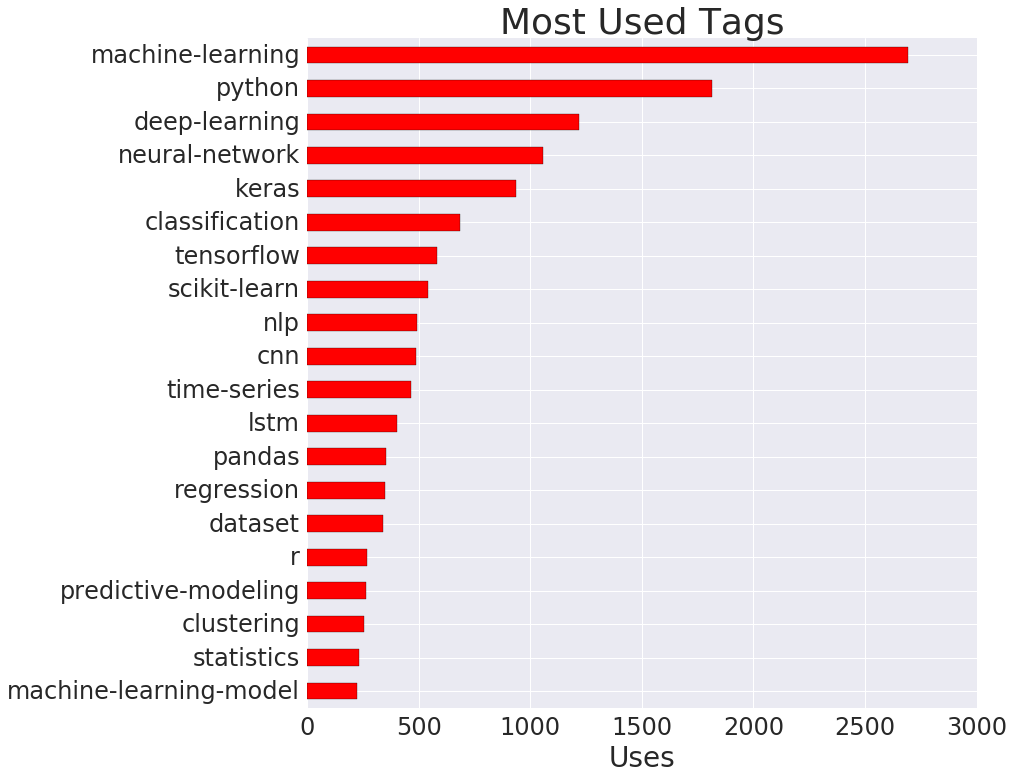

In [11]:
# plot most used tags 
# --> set function parameters for use proxy
use_params = [top20_used_tags, 'red', 'Most Used Tags', 'Uses']
# --> call plot_barh for use proxy
plot_barh(use_params[0], use_params[1], use_params[2], use_params[3])

The single most frequently used tag in DSSE posts is `machine-learning`, followed by `python`, with only approximately 2/3 the number of uses. The next several most used tags are all subcategories of machine learning, with `deep-learning` being the most used of those machine learning subcategory tags.

### Most Viewed Tags

Next, we find the top twenty most viewed tags, using the same method as above but with the `Views` column.

In [12]:
# sort by most viewed tags and view top 20
top20_viewed_tags = tag_popularity.sort_values(by='Views', ascending=False)['Views'].head(20)
print("TOP 20 MOST VIEWED TAGS:")
print(top20_viewed_tags)

TOP 20 MOST VIEWED TAGS:
python              537585
machine-learning    388499
keras               268608
deep-learning       233628
pandas              201787
neural-network      185367
scikit-learn        128110
tensorflow          121369
classification      104457
dataframe            89352
lstm                 74458
nlp                  71382
cnn                  70349
time-series          64134
numpy                49767
regression           49451
dataset              43151
pytorch              40240
csv                  38654
clustering           33928
Name: Views, dtype: int64


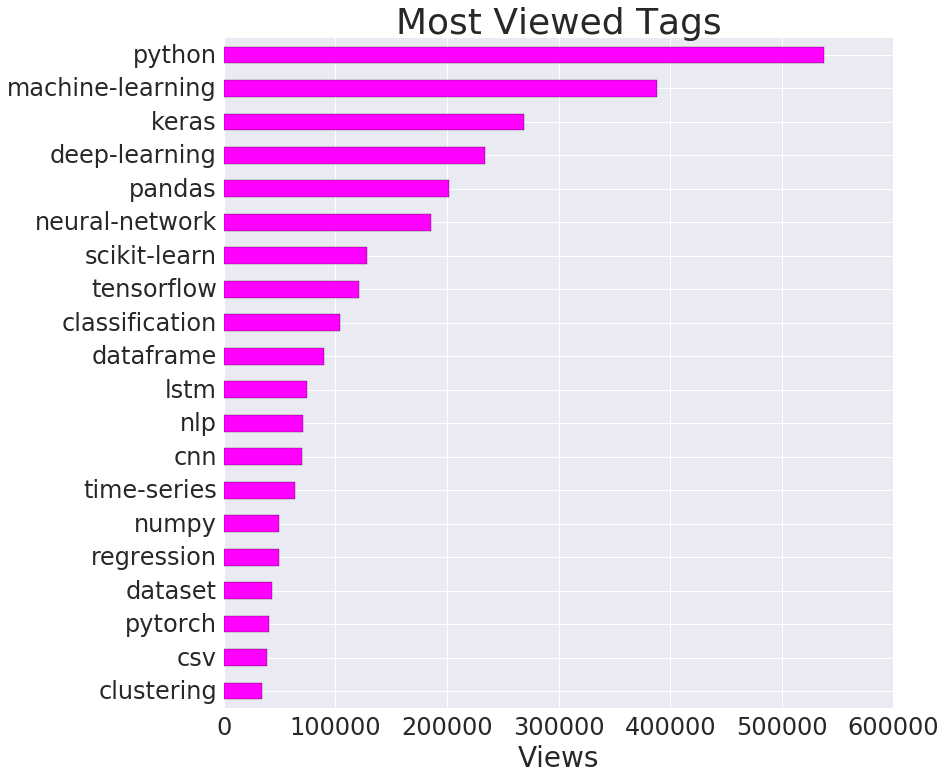

In [13]:
# plot most viewed tags 
# --> set function parameters for view proxy
view_params = [top20_viewed_tags, 'magenta', 'Most Viewed Tags', 'Views']
# --> call plot_barh for view proxy
plot_barh(view_params[0], view_params[1], view_params[2], view_params[3])

In comparison to the most used tags, `python` overtakes `machine-learning` for the most viewed tag, with Python views being viewed approximately a third more than machine learning posts. The `pandas` tag is also significantly higher in rank for views than uses, but otherwise the most viewed tags are also dominated by tags related to subdivisions of machine learning.

### Highest Scored Tags

Here we identify the top twenty highest scored tags, where the score is calculated as the sum of scores from all posts carrying that tag.

In [14]:
# sort by highest scored tags and view top 20
top20_score_tags = tag_popularity.sort_values(by='Score', ascending=False)['Score'].head(20)
print("TOP 20 HIGHEST SCORED TAGS:")
print(top20_score_tags)

TOP 20 HIGHEST SCORED TAGS:
machine-learning        2515
python                  1475
deep-learning           1127
neural-network          1021
keras                    785
classification           701
scikit-learn             507
nlp                      455
cnn                      452
tensorflow               417
time-series              375
lstm                     345
pandas                   283
regression               277
dataset                  235
predictive-modeling      227
image-classification     216
feature-selection        205
statistics               188
data-mining              186
Name: Score, dtype: int64


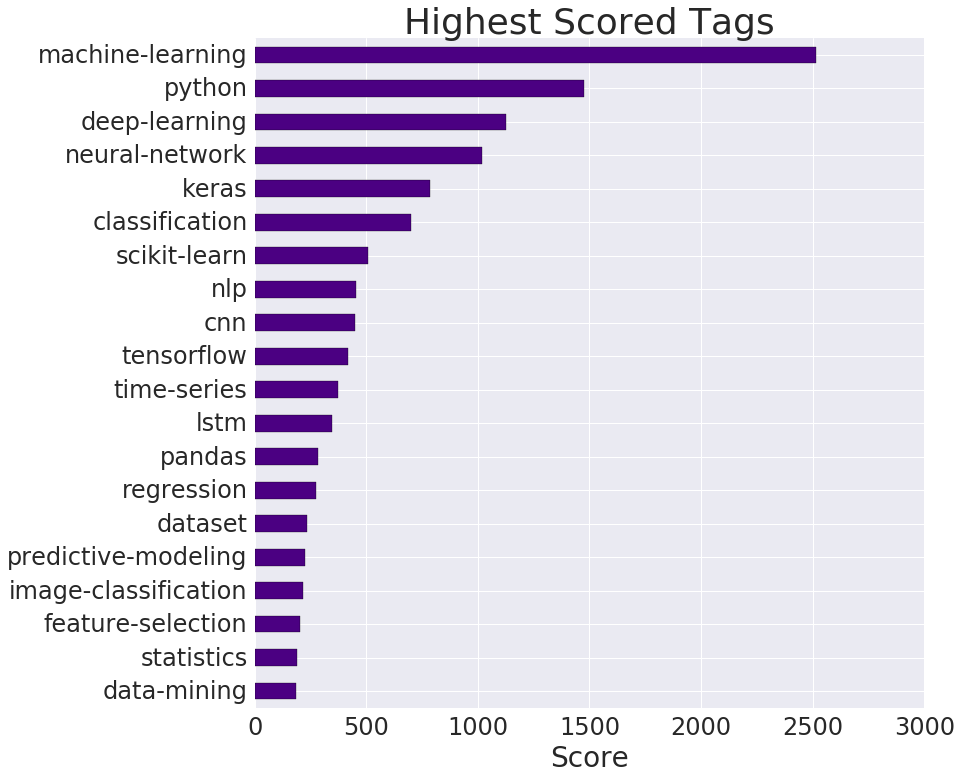

In [15]:
# plot highest scored tags 
# --> set function parameters for score proxy
score_params = [top20_score_tags, 'indigo', 'Highest Scored Tags', 'Score']
# --> call plot_barh for score proxy
plot_barh(score_params[0], score_params[1], score_params[2], score_params[3])

This plot looks very similar to the most-used-tags plot, with the same tags in the top fifteen for both proxies (although the order is slightly rearranged below the top six tags). The number of uses for each tag is also very close to the total score associated with the tag. This leads us to conclude that tag use and score are highly correlated, with tags being used more often having higher scores, and vice versa.

### Most Answered Tags

Analogously to the other proxies above, we next investigate the top twenty most answered tags on the site.

In [16]:
# sort by most answered tags and view top 20
top20_answer_tags = tag_popularity.sort_values(by='Answers', ascending=False)['Answers'].head(20)
print("TOP 20 MOST ANSWERED TAGS:")
print(top20_answer_tags)

TOP 20 MOST ANSWERED TAGS:
machine-learning       2313
python                 1507
deep-learning           877
neural-network          824
keras                   654
classification          651
scikit-learn            518
pandas                  394
nlp                     369
cnn                     362
tensorflow              353
regression              309
time-series             303
dataset                 295
clustering              283
lstm                    244
predictive-modeling     220
feature-selection       214
r                       211
linear-regression       202
Name: Answers, dtype: int64


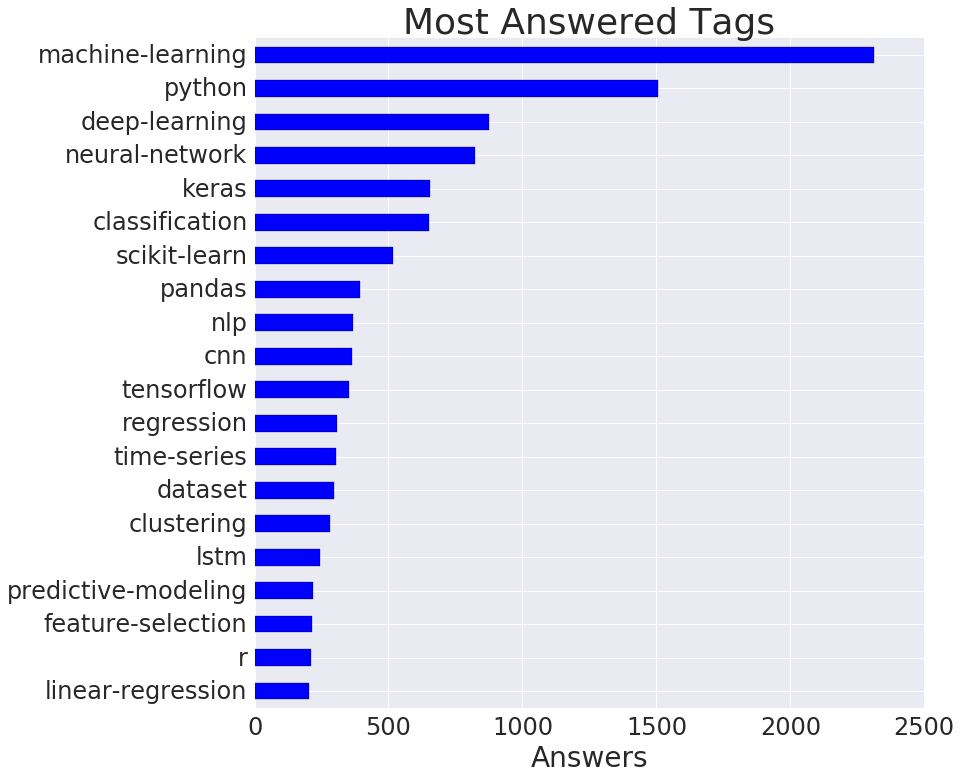

In [17]:
# plot most answered tags 
# --> set function parameters for answer proxy
answer_params = [top20_answer_tags, 'blue', 'Most Answered Tags', 'Answers']
# --> call plot_barh for answer proxy
plot_barh(answer_params[0], answer_params[1], answer_params[2], answer_params[3])

We see that the most answered tags are also very similar to the most used and highest scored tags, with the same top six rankings across all proxies. Additionally, the same tags are among the top fourteen tags in all proxies, but with somewhat different rankings in each.

### Most Favorited Tags

Finally, we determine the top twenty most favorited tags on the site. As we observe below, this list is very similar to the all of the other proxy lists compiled above.

In [18]:
# sort by most favorited tags and view top 20
top20_favorite_tags = tag_popularity.sort_values(by='Favorites', ascending=False)['Favorites'].head(20)
print("TOP 20 MOST FAVORITED TAGS:")
print(top20_favorite_tags)

TOP 20 MOST FAVORITED TAGS:
machine-learning        575
python                  325
deep-learning           266
neural-network          227
keras                   181
classification          153
scikit-learn            113
cnn                     100
time-series              97
nlp                      94
tensorflow               88
lstm                     88
image-classification     59
dataset                  54
feature-selection        51
feature-engineering      47
regression               47
predictive-modeling      44
pandas                   42
xgboost                  41
Name: Favorites, dtype: int64


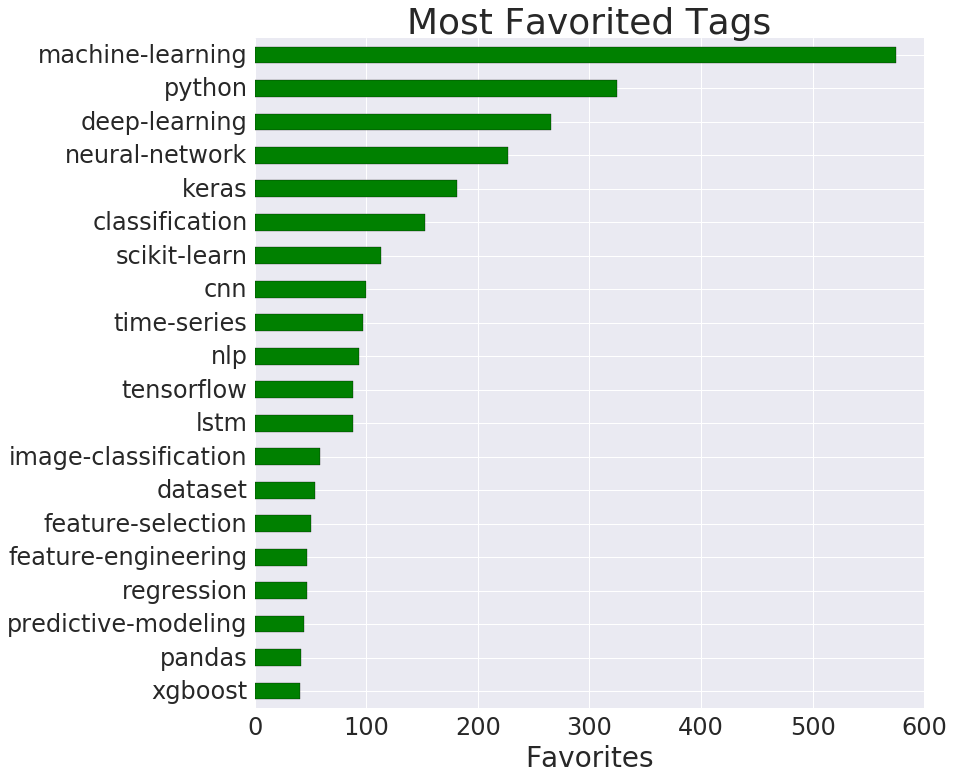

In [19]:
# plot most favorited tags 
# --> set function parameters for favorite proxy
favorite_params = [top20_favorite_tags, 'green', 'Most Favorited Tags', 'Favorites']
# --> call plot_barh for favorite proxy
plot_barh(favorite_params[0], favorite_params[1], favorite_params[2], favorite_params[3])

### Comparing Popularity Proxies

In order to better visualize how the tag popularity varies by proxy, we compare all of the plots from above side by side below. It is immediately obvious that the variables we used to determine tag popularity are all at least somewhat, if not very closely, correlated. The top five most popular tags are, in order, `machine-learning`, `python`, `deep-learning`, `neural-network`, and `keras`. This is the top five ranking in all of our popularity proxies but one: the most viewed. This is the only proxy where `python` overtakes `machine-learning` as the number one tag, where `keras` surpasses `deep-learning` and `neural-network`, and where `pandas` is among the top five tags, knocking `neural-network` to sixth.

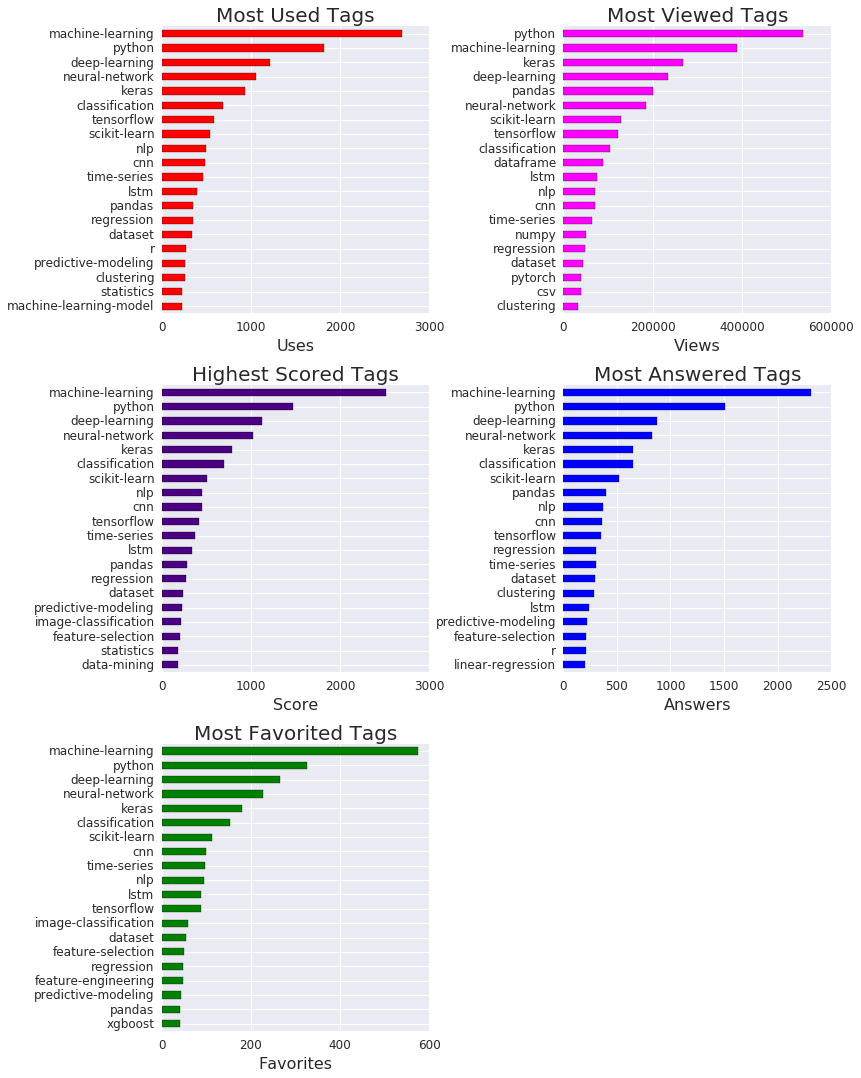

In [20]:
# build dataframe of plot parameters
params = pd.DataFrame()
params['Uses'] = use_params[1:]
params['Views'] = view_params[1:]
params['Score'] = score_params[1:]
params['Answers'] = answer_params[1:]
params['Favorites'] = favorite_params[1:]
# plot all tag plots together
fig = plt.figure(figsize=(12,18))
fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(hspace=0.25)
for i in range(0,5):
    ax = fig.add_subplot(3,2,i+1)
    plot_series = tag_popularity.iloc[:,i].sort_values(ascending=False).head(20)
    plot_series.sort_values().plot.barh(color=params.iloc[0,i])
    ax.set_title(params.iloc[1,i], fontsize=20)
    ax.set_xlabel(params.iloc[2,i], fontsize=16)
    ax.tick_params(axis='both', labelsize=12)
    plt.locator_params(axis='x', nbins=5)

## Investigating Relationships between Tags

Now that we've identified the DSSE site's most popular tags, we want to explore the relationships between them. In essence, we want to identify what relationships exist, and how strong those relationships are, between various tags. 

One way we could analytically find relationships between multiple tags is to count up the number of times each possible combination of tags occurs. This, however, could become quite cumbersome and time consuming. Instead, we can use domain knowledge to attack this problem.

### Using Domain Knowledge to Determine Tag Relationships

Rather than implementing a strictly analytical or computational approach to the problem, we can obtain a general understanding of the existing relationships between DSSE tags and their strengths with our knowledge of the data science field alone.

For example, we know that a number of tags represent subcategories of the broader topic of machine learning, so these tags would be related in some way to the `machine-learning` tag, but we do not yet know what this exact relationship is. Similarly, pandas is a Python library, so the `pandas` tag should be related somehow to the `Python` tag. On the other hand, R and Python are separate languages, so we do not expect to see a strong relationship between the two corresponding tags.

Let's look at the top ten tags for each popularity proxy and compare them to each other.

In [21]:
# print tags common to all top ten lists
top20_list = [top20_used_tags, top20_viewed_tags, top20_score_tags,
              top20_answer_tags, top20_favorite_tags]
top10_dict = {}
for i in range(0,10):
    for top20 in top20_list:
        tag = top20.head(10).index[i]
        if tag in top10_dict:
            top10_dict[tag] += 1
        else:
            top10_dict[tag] = 1

for i in top10_dict:
    print(i, ":", top10_dict[i])

python : 5
neural-network : 5
cnn : 4
scikit-learn : 5
pandas : 2
tensorflow : 3
machine-learning : 5
time-series : 1
nlp : 4
deep-learning : 5
keras : 5
classification : 5
dataframe : 1


Of the top ten tags of each popularity proxy, we see that the following tags are common among the majority (at least three out of five) of proxies:
- [`machine-learning`](https://datascience.stackexchange.com/tags/machine-learning/info) -- Machine Learning = methods and principles of building computer algorithms that improve automatically with experience;
- [`python`](https://datascience.stackexchange.com/tags/python/info) -- Python = programming language;
- [`deep-learning`](https://datascience.stackexchange.com/questions/tagged/deep-learning) -- Deep Learning = area of machine learning using hierarchical architecture and neural networks to learn complex functions;
- [`neural-network`](https://datascience.stackexchange.com/questions/tagged/neural-network) -- Neural Networks = statistical models using groups of artificial neurons tuned by learning algorithms;
- [`keras`](https://datascience.stackexchange.com/questions/tagged/keras) -- Keras = neural network library in Python;
- [`classification`](https://datascience.stackexchange.com/questions/tagged/classification) -- Classification = predictive categorization algorithms in machine learning;
- [`scikit-learn`](https://datascience.stackexchange.com/questions/tagged/scikit-learn) -- SciKit-learn = Python module for machine learning, data mining, and data analysis, built on NumPy, SciPi, and matplotlib;
- [`nlp`](https://datascience.stackexchange.com/questions/tagged/nlp) -- Natural Language Processing (NLP) = field of computer science, artificial intelligence, and linguistics dealing with interactions between computers and human languages;
- [`cnn`](https://datascience.stackexchange.com/questions/tagged/cnn) -- Convolutional Neural Networks (CNN or ConvNets) = neural network tools used for image processing and classification;
- [`tensorflow`](https://datascience.stackexchange.com/questions/tagged/tensorflow) -- TensorFlow = Python library for machine learning.

All of the above tags are intimately related. Three of the tags correspond to machine learning libraries for Python, which is itself a top-ten tag. Two of those libraries are specifically related to neural networks, which are used in deep learning, which is a subset of machine learning, all of which are represented in the top ten by their own tags. Of the top ten tags listed above, nine are directly connected to machine learning, and six are specific to deep learning and/or neural networks.

We can safely conclude that, at this time, machine learning, deep learning, and neural networks are the hottest topics in the field of data science.

## Tracking Interest in Data Science Topics Over Time

Although we have identified the most popular topics in data science **currently**, we need to determine if this trend is just a fad or if the topics of machine learning, deep learning, and neural networks will remain topics of interest for the foreseeable future. We can predict this by examing their popularity over time using all of the available data from the DSSE database. 

Here, we gather all of the questions asked on the DSSE site, including the posts' creation dates and tags, and calculate the percentage of questions related to the topics of interest asked over time (here we are using the "most used" popularity proxy).

Since two of the three topics are so closely related, we condense the three hottest data science topics into two categories: 
1. general machine learning, encompassing any subfield, including deep learning, and
2. deep learning and neural networks.

Before performing any calculations, we first need to classify questions as either belonging to category 1, category 2, or no category. For simplicity, we will only consider the top ten tags across the majority of popularity proxies, as calculated above, in our classification. Therefore, we will consider questions with any of the following tags as belonging to category 1 (machine learning):
- `machine-learning`;
- `deep-learning`;
- `neural-network`;
- `keras`;
- `classification`;
- `scikit-learn`;
- `nlp`;
- `cnn`;
- `tensorflow`;

and questions with any of the following tags will be considered as belonging to category 2 (deep learning and neural networks):
- `deep-learning`
- `neural-network`
- `keras`
- `nlp`
- `cnn`
- `tensorflow`

In [22]:
# read in query results to dataframe
all_questions = pd.read_csv('all_questions.csv', parse_dates=['CreationDate'])

In [23]:
# reformat 'Tags' columns
all_questions['Tags'] = all_questions['Tags'].str.replace('<', '').str.replace('>',',').str[:-1].str.split(',')

In [24]:
# categorize questions as machine learning, deep learning, or none
# --> set lists of machine learning + deep learning / neural network tags
ml_list = ['machine-learning', 'deep-learning', 'neural-network', 'keras', 
           'classification', 'scikit-learn', 'nlp', 'cnn', 'tensorflow']
dlnn_list = ['deep-learning', 'neural-network', 'keras', 'nlp', 'cnn', 'tensorflow']
# --> define function to categorize questions
def categorize(entry_list):
    isML = False
    isDLNN = False
    for entry in entry_list:
        if entry in ml_list:
            isML = True
        if entry in dlnn_list:
            isDLNN = True
    if isDLNN:
        return 2
    elif isML:
        return 1
    else:
        return 0
# --> add 'Category' column to dataframe             
all_questions['Category'] = all_questions['Tags'].apply(categorize)

In [25]:
print(all_questions['CreationDate'].min(), all_questions['CreationDate'].max())

2014-05-13 23:58:30 2020-01-19 03:01:03


The questions in our dataset cover a time range of approximately five and a half years. We can divide this into yearly quarters, or periods of three months, to track the interest in machine learning and deep learning over time.

Below, we sort the posts into yearly quarters, count the number of questions posted per time period for each category and in total, and plot the results. We also separately plot the percentages of questions belonging to each category asked per time period. 

In [ ]:
# define function to get yearly quarter of creation date
def getQuarter(date):
    year = date.year
    month = date.month
    quarter = int(month / 4) + 1
    return '{}Q{}'.format(year, quarter)
# add yearly quarter column to dataframe
all_questions['Quarter'] = all_questions['CreationDate'].apply(getQuarter)

In [61]:
# create dataframes of ML + DL/NN questions
# --> machine learning category encompasses deep learning, so contains category 1 + 2 questions
ml_questions = all_questions[(all_questions['Category'] == 1) | 
                             (all_questions['Category'] == 2)]
dlnn_questions = all_questions[all_questions['Category'] == 2]

In [28]:
# count number of ML, DL/NN, and total questions per quarter
ml_counts = ml_questions.groupby('Quarter').size()
dlnn_counts = dlnn_questions.groupby('Quarter').size()
total_counts = all_questions.groupby('Quarter').size()

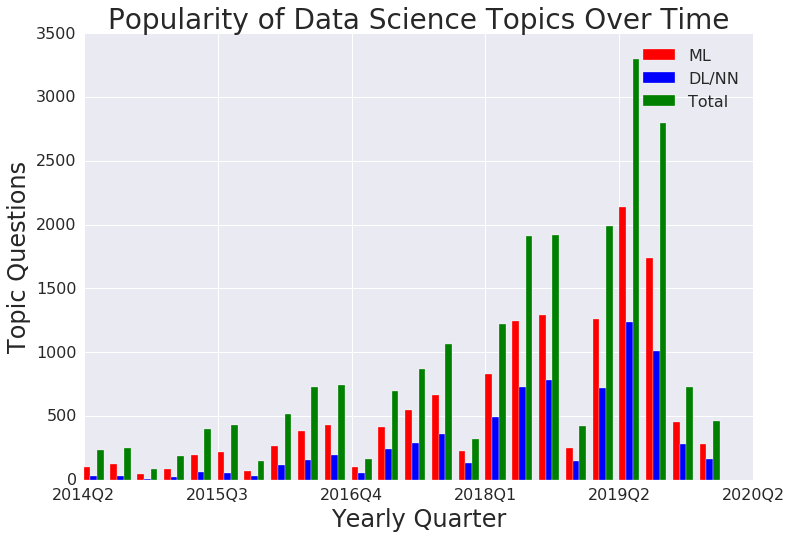

In [86]:
# initialize figure + axis
fig, ax = plt.subplots(figsize=(12,8))

# set x-axis labels
xlabels = []
for i, ml in enumerate(ml_counts.index):
    if i % 5 == 0:
        xlabels.append(ml)
last_qtr = ml_counts.index[-1]
lqs = last_qtr.split('Q')
next_qtr = lqs[0] + 'Q' + str(int(lqs[1]) + 1)
xlabels.append(next_qtr)

# set bar width
barw = 0.25
# set left edges of bars
l1 = np.arange(len(ml_counts))
l2 = [x + barw for x in l1]
l3 = [x + barw for x in l2]
# plot bar charts
plt.bar(l1, ml_counts, width=barw, color='red', edgecolor='white', label='ML')
plt.bar(l2, dlnn_counts, width=barw, color='blue', edgecolor='white', label='DL/NN')
plt.bar(l3, total_counts, width=barw, color='green', edgecolor='white', label='Total')
# set titles and axes
ax.set_title('Popularity of Data Science Topics Over Time', fontsize=28)
ax.set_xlabel('Yearly Quarter', fontsize=24)
ax.set_ylabel('Topic Questions', fontsize=24)
ax.tick_params(axis='both', labelsize=16)
ax.set_xticklabels(xlabels)

plt.legend(fontsize=16)
plt.show()

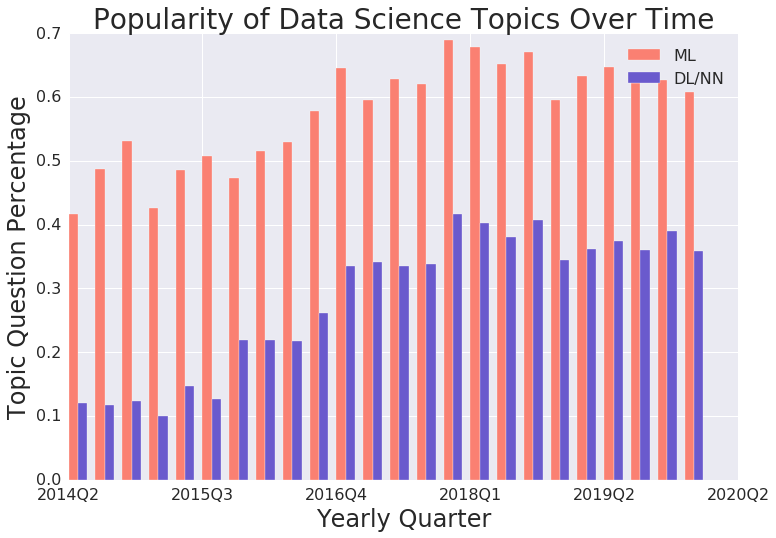

In [87]:
fig, ax = plt.subplots(figsize=(12,8))
barw = 0.35
l1 = np.arange(len(ml_counts))
l2 = [x + barw for x in l1]
plt.bar(l1, ml_counts / total_counts, width=barw, color='salmon', edgecolor='white', label='ML')
plt.bar(l2, dlnn_counts / total_counts, width=barw, color='slateblue', edgecolor='white', label='DL/NN')

ax.set_title('Popularity of Data Science Topics Over Time', fontsize=28)
ax.set_xlabel('Yearly Quarter', fontsize=24)
ax.set_ylabel('Topic Question Percentage', fontsize=24)
ax.tick_params(axis='both', labelsize=16)
ax.set_xticklabels(xlabels)

plt.legend(fontsize=16)
plt.show()

We can see from the two plots above that interest in machine learning and deep learning has increased over the last several years, with the percentage of total questions related to either topic growing consistently over time. Recently, this growth has plateaued, but the interest is still large (over 60% for machine learning and nearly 40% for deep learning), and there are no indications it will decrease any time soon. We are confident in our recommendation that machine learning and deep learning should be the focus for our future content. If we have to choose a single topic that is best to write about, we would suggest deep learning, as it is less broad and has seen a larger increase in interest (from 10% to 40%) in the last five years.

# Conclusion

In this project, we explored and analyzed data from the Data Science Stack Exchange site to determine the most popular topics in data science right now. We concluded that machine learning, specifically deep learning, is currently the hottest topic of interest in the data science community and the topic we should focus on for writing content aimed at people who want to learn about the field.